# 1. Ödev

Bu ödevde herhangi bir şekilde varolan sofistike kütüphaneler kullanılamaz. Sadece rastgele sayı üretmek için kütüphane kullanabilirsiniz. Dokümanları vektörize etmek, uzaklık hesapları yapmak vs. gibi her şey için gereken kodu kendiniz yazmalısınız.

Önemli not: ChatGpt'ye ben de kod yazdırabiliyorum :) ChatGPT'den alınan cevaplar kopya muamelesi görecektir.

Ödeviniz Python 3 ile implement ediniz

**Soru 1** Bu soruda locality sensitive hashing (LSH) metodu yazacaksınız. Metodun çağrımı şu şekildedir: lsh(klasor_adi, k, b, r, similarity_threshold). 
- klasor_adi indeksin kurulacağı dosyaları tutan klasörün adresidir. Klasörün içinde birçok txt dosyası var olduğunu varsayabilirsiniz.
- k 'k-shingle'in k değeridir. 
- b band sayısının değeridir.
- r her banddaki satır (row) sayısıdır. 

Verilen  klasördeki dosyaları okuyarak LSH sistemi kurun. Bunun için her kelime bir token olacaktır. Öncelikle her kelime küçük harflere çevrilmeli ve noktalama işaretleri çıkarılmalı. Eğer k = 2 ise, “Ali okula gitti.” cümlesindeki ‘shingle’lar “ali okula” ve “okula gitti” olmalı. 

MinHash imzaları için 10 tane hash fonksiyonu kullanınız. 

Not: Sorunun cevabını kontrol ederken ben size verilen dosyalar ile aynı formatta olan farklı dosyalar kullanacağım.


In [19]:
def zero_vec(length): # length uzunluğunda 0'lardan oluşan bir vektör döndürür
    vec = []
    for i in range(length):
        vec.append(0)
    return vec

import warnings
warnings.filterwarnings('ignore')

def min_hash(index_range, num_of_hash_func):
    from sympy import randprime
    original_indexes = list(range(index_range))
    
    hash_functions = []
    for i in range(num_of_hash_func):
        a = randprime(1, 100000000)
        b = randprime(1, 100000000)
        if [a, b] not in hash_functions:
            hash_functions.append([a, b])
        else:
            i -= 1
        
    new_indexes = []

    for i in range(num_of_hash_func):
        a = hash_functions[i][0]
        b = hash_functions[i][1]

        hashed_list = [((a*x + b) % index_range**3) % index_range for x in original_indexes] 
        shuffled_list = [None] * index_range
        for i, index in enumerate(hashed_list):
            shuffled_list[index] = original_indexes[i]
        new_indexes.append(shuffled_list)
    
    return new_indexes

In [4]:
def create_hash_functions(num_hash_functions, num_of_shingles):
    import random
    hash_functions = []
    for i in range(num_hash_functions):
        a = random.randint(1, num_of_shingles-1)
        b = random.randint(1, 10000000)
        if [a, b] not in hash_functions:
            hash_functions.append([a, b])
        else:
            i -= 1
        
    return hash_functions

In [3]:
def transpose_dict(dict):
    matrix = []
    for i in dict.keys():
        matrix.append(dict[i])

    transposed = []
    for i in range(len(matrix[0])):
        temp = []
        for j in range(len(matrix)):
            temp.append(matrix[j][i])
        transposed.append(temp)

    transposed_dict = {}
    
    for key in range(1,len(transposed)+1):
        transposed_dict[key] = transposed[key-1]
    del transposed 
    del matrix
    return transposed_dict

In [8]:
def lsh(klasor_adi, k, b, r):
    import os
    import string
    import sys
    import random

    matrix_represent = dict() # shingle'larin matrixteki temsilini tutacak

    dosya_isimleri = os.listdir(klasor_adi) # klasorun icindeki tum dosyalarin adini aliyoruz

    # tüm dosyaları tek tek oku
    for dosya in dosya_isimleri: 
        content = open(klasor_adi + "/" + dosya, "r").read()
        content = content.replace("\n", " ")
        content = content.lower()
        content = content.translate(str.maketrans('', '', string.punctuation))
        content = " ".join(content.split())        
        content = content.split(" ")
        for i in range(len(content) - k):
            shingle =  content[i:i + k]
            shingle = " ".join(shingle)
            if shingle not in matrix_represent.keys():
                vec = zero_vec(len(dosya_isimleri))
                vec[dosya_isimleri.index(dosya)] = 1
                matrix_represent[shingle] = vec
            else:
                matrix_represent[shingle][dosya_isimleri.index(dosya)] = 1

    

    num_of_shingles = len(matrix_represent.keys()) # shingle sayisi

    different_permutations = min_hash(num_of_shingles, b*r) # farklı index permütasyonları oluşturuluyor

    signature_matrix = dict() # signature matrix oluşturuluyor
    transposed_matrix = transpose_dict(matrix_represent) # matrix_represent transpozu alınıyor

    for permutation in different_permutations: # her bir permütasyon için 
        i = different_permutations.index(permutation)
        temp = []
        for j in transposed_matrix.keys(): # her bir doküman için
            for index in range(len(permutation)): # her bir permütasyonun içindeki indexler için
                if transposed_matrix[j][index] == 1:
                    temp.append(index)
                    break 
            signature_matrix[i] = temp

    del different_permutations

    # signature matrix'i b ve r değerlerine göre bölüyoruz
    signature_matrix_bolunmus = dict()
    for i in range(b): # signature matrix'i b'ye bölüyoruz
        signature_matrix_bolunmus[i] = []
    
        for doc in range(len(signature_matrix[0])): # her bir doküman için
            temp = []
            for j in range(r):
                temp.append(signature_matrix[i+j][doc])
            signature_matrix_bolunmus[i].append(temp)
    
    
    buckets = dict() # bucket'lar oluşturuluyor

    for i in range(b): # her bir b için
        buckets[i] = dict()
        for j in range(len(signature_matrix_bolunmus[i])): # her bir doküman için
            numbers = signature_matrix_bolunmus[i][j]
            concatenated_str = ''.join(str(num) for num in numbers)
            unicode_values = [ord(char) for char in concatenated_str]
            unicode_values_concatenated = ''.join(str(num) for num in unicode_values)
            if unicode_values_concatenated not in buckets[i].keys():
                buckets[i][unicode_values_concatenated] = [dosya_isimleri[j]]
            else:
                buckets[i][unicode_values_concatenated].append(dosya_isimleri[j])

    return buckets, matrix_represent, dosya_isimleri

In [9]:
buckets, matrix_represent, dosya_isimleri   = lsh("docs", 3, 10, 3)

**Soru 2)**  Önceki soruda hazırladığınız LSH indeksini kullanarak verilen bir dosyanın muhtemel benzerleri olan dosyaları ve o dokümanlar ile olan jaccard benzerliği sıralı bir şekilde ekrana yazdıran bir method yazınız.  En çok benzeyen dokümanlar ilk yazılmalı. Çıktının formatı aşağıdaki örnekteki gibi olmalı.  Örnekte sadece 2 dosya döndüğü varsayılmıştır.

a.txt 0.7
b.txt 0.65
Toplam 2 dosya bulunmuştur.


In [14]:
def jaccard_similarity(doc1, doc2):
    intersection = 0
    for i in range(len(doc1)):
        if doc1[i] == doc2[i]:
            intersection += 1
    
    union = len(doc1) + len(doc2) - intersection
    return intersection / union

In [10]:
def query(input_file, shingle_matrix, doc_names, b,r):
    import os
    import string
    matrix_representation = shingle_matrix

    candidate_pairs = [input_file] # input_file ile benzer olabilecek dosyaları tutacak
    doc_names.append(input_file) # input_file'ı doc_names'a ekliyoruz

    content = open(input_file, "r").read()
    content = content.replace("\n", " ")
    content = content.lower()
    content = content.translate(str.maketrans('', '', string.punctuation))
    content = " ".join(content.split())        
    content = content.split(" ")
    
    k = len(list(matrix_representation.keys())[0].split(" "))

    for shingle in matrix_representation.keys(): # input_file için matrix_representation'da yer açma
        matrix_representation[shingle].append(0)

    

    for i in range(len(content) - k): # input_file için matrix_representation'a değer atama
        shingle =  content[i:i + k]
        shingle = " ".join(shingle)
        if shingle in matrix_representation.keys(): 
            matrix_representation[shingle][-1] = 1
        else:
            vec = zero_vec(len(doc_names))
            vec[-1] = 1
            matrix_representation[shingle] = vec

    
    
    num_of_shingles = len(matrix_representation.keys()) # shingle sayisi

    different_permutations = min_hash(num_of_shingles, b*r) # farklı index permütasyonları oluşturuluyor

    signature_matrix = dict() # signature matrix oluşturuluyor
    transposed_matrix = transpose_dict(matrix_representation) # matrix_representation transpozu alınıyor

    for permutation in different_permutations: # her bir permütasyon için 
        i = different_permutations.index(permutation)
        temp = []
        for j in transposed_matrix.keys(): # her bir doküman için
            for index in permutation: # her bir permütasyonun içindeki indexler için
                if transposed_matrix[j][index] == 1:
                    temp.append(index)
                    break 
            signature_matrix[i] = temp

    del different_permutations

    # signature matrix'i b ve r değerlerine göre bölüyoruz
    signature_matrix_bolunmus = dict()
    for i in range(b): # signature matrix'i b'ye bölüyoruz
        signature_matrix_bolunmus[i] = []
    
        for doc in range(len(signature_matrix[0])): # her bir doküman için
            temp = []
            for j in range(r):
                temp.append(signature_matrix[i+j][doc])
            signature_matrix_bolunmus[i].append(temp)
    
    
    buckets = dict() # bucket'lar oluşturuluyor

    for i in range(b): # her bir b için

        buckets[i] = dict()

        for j in range(len(signature_matrix_bolunmus[i])): # her bir doküman için

            numbers = signature_matrix_bolunmus[i][j]
            concatenated_str = ''.join(str(num) for num in numbers)
            unicode_values = [ord(char) for char in concatenated_str]
            unicode_values_concatenated = ''.join(str(num) for num in unicode_values)

            if unicode_values_concatenated not in buckets[i].keys():
                buckets[i][unicode_values_concatenated] = [doc_names[j]]
            else:
                buckets[i][unicode_values_concatenated].append(doc_names[j])
            
 
    for band in buckets.keys(): 
        for bucket in buckets[band].keys():
            if input_file in buckets[band][bucket]:
                if len(buckets[band][bucket]) > 1:
                    for doc in buckets[band][bucket]:
                        if doc != input_file and doc not in candidate_pairs:
                            candidate_pairs.append(doc)

    doc_indexes = []
    for doc in candidate_pairs:
        doc_indexes.append(doc_names.index(doc))
    
    temp_dict = {}
    for key in matrix_representation.keys():
        temp = []
        for index in doc_indexes:
            temp.append(matrix_representation[key][index])
        temp_dict[key] = temp
    matrix_representation = temp_dict


    doc_values = {}

    for doc in candidate_pairs:
        doc_values[doc] = []

    for shingle in matrix_representation.keys():
        for doc in candidate_pairs:
            doc_values[doc].append(matrix_representation[shingle][candidate_pairs.index(doc)])
    
    

    remove_indexes = []
    for idx in range(len(doc_values[input_file])):
        is_all_zero = True
        for doc in candidate_pairs:
            if doc_values[doc][idx] != 0:
                is_all_zero = False
                break
        
        if is_all_zero == True:
            remove_indexes.append(idx)

    

    for doc in candidate_pairs:
        temp = []
        for idx in range(len(doc_values[doc])):
            if idx not in remove_indexes:
                temp.append(doc_values[doc][idx])
        doc_values[doc] = temp
        
    similarities = dict()
    for doc in candidate_pairs[1:]:
        similarity = round(jaccard_similarity(doc_values[input_file], doc_values[doc]),3)
        similarities[doc] = similarity

    similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    for sim in similarities:
        print(sim[0], sim[1], end=" ") 

    print("Toplam " + str(len(similarities)) + " adet benzer doküman bulundu.")

In [12]:
buckets, shingle_matrix, doc_names = lsh("docs", 2,10,2)

In [ ]:
query("sorgu.txt", shingle_matrix, doc_names, 20,3) #yukarıdaki lsh'ta k değeri kaçsa burda da k değeri o

1439.txt 0.357 1846.txt 0.335 1124.txt 0.318 Toplam 3 adet benzer doküman bulundu.


**Soru 3)** Bu soruda ödev ile verilen  metin dosyalarını kullanarak LSH indeksi kurup farklı k, b, ve r değerlerinin sonuç üzerindeki etkisine bakacaksınız.
Spesifik olarak yapacağınız şunlar.
- Ödevde verilen docs klasöründeki dokümanları b=5, r=4 iken k=2,3,4 değerlerini kullanarak 3 farklı LSH indeksi kurunuz. Ardından ödevde verilen sorgu.txt dosyasını bu 3 ayrı indekste aratıp toplamda kaç doküman döndüğü gösteren bir 'bar chart' çiziniz. 
- k=3, r=4 iken b değerini 3,4,5 olarak değiştiriniz ve birinci şıktaki gibi toplamda kaç doküman döndüğü gösteren bir 'bar chart' çiziniz. 
- k=3, r=4 iken r değerini 3,4,5 olarak değiştiriniz ve birinci şıktaki gibi toplamda kaç doküman döndüğü gösteren bir 'bar chart' çiziniz.

Not:  Bu soruda ikinci sorudaki metotta ufak bir değişikliğe gidip ekrana bir şey bastırmadan sadece  kaç doküman bulunduğunu dönen bir metot olarak tanımlayın. Bu yeni metodu aşağıda 3. soru için tanımlanan yerde yapın.

In [11]:
def query2(input_file, shingle_matrix, doc_names, b,r):
    import os
    import string

    matrix_representation = shingle_matrix

    candidate_pairs = [input_file]
    doc_names.append(input_file)

    content = open(input_file, "r").read()
    content = content.replace("\n", " ")
    content = content.lower()
    content = content.translate(str.maketrans('', '', string.punctuation))
    content = " ".join(content.split())        
    content = content.split(" ")
    
    k = len(list(matrix_representation.keys())[0].split(" "))

    for shingle in matrix_representation.keys():
        matrix_representation[shingle].append(0)

    

    for i in range(len(content) - k):
        shingle =  content[i:i + k]
        shingle = " ".join(shingle)
        if shingle in matrix_representation.keys(): 
            matrix_representation[shingle][-1] = 1
        else:
            vec = zero_vec(len(doc_names))
            vec[-1] = 1
            matrix_representation[shingle] = vec

    
    
    num_of_shingles = len(matrix_representation.keys()) # shingle sayisi

    different_permutations = min_hash(num_of_shingles, b*r) # farklı index permütasyonları oluşturuluyor

    signature_matrix = dict() # signature matrix oluşturuluyor
    transposed_matrix = transpose_dict(matrix_representation) # matrix_representation transpozu alınıyor

    for permutation in different_permutations: # her bir permütasyon için 
        i = different_permutations.index(permutation)
        temp = []
        for j in transposed_matrix.keys(): # her bir doküman için
            for index in permutation: # her bir permütasyonun içindeki indexler için
                if transposed_matrix[j][index] == 1:
                    temp.append(index)
                    break 
            signature_matrix[i] = temp

    del different_permutations

    # signature matrix'i b ve r değerlerine göre bölüyoruz
    signature_matrix_bolunmus = dict()
    for i in range(b): # signature matrix'i b'ye bölüyoruz
        signature_matrix_bolunmus[i] = []
    
        for doc in range(len(signature_matrix[0])): # her bir doküman için
            temp = []
            for j in range(r):
                temp.append(signature_matrix[i+j][doc])
            signature_matrix_bolunmus[i].append(temp)
    
    
    buckets = dict() # bucket'lar oluşturuluyor

    for i in range(b): # her bir b için

        buckets[i] = dict()

        for j in range(len(signature_matrix_bolunmus[i])): # her bir doküman için

            numbers = signature_matrix_bolunmus[i][j]
            concatenated_str = ''.join(str(num) for num in numbers)
            unicode_values = [ord(char) for char in concatenated_str]
            unicode_values_concatenated = ''.join(str(num) for num in unicode_values)

            if unicode_values_concatenated not in buckets[i].keys():
                buckets[i][unicode_values_concatenated] = [doc_names[j]]
            else:
                buckets[i][unicode_values_concatenated].append(doc_names[j])
            
 
    for band in buckets.keys(): 
        for bucket in buckets[band].keys():
            if input_file in buckets[band][bucket]:
                if len(buckets[band][bucket]) > 1:
                    for doc in buckets[band][bucket]:
                        if doc != input_file and doc not in candidate_pairs:
                            candidate_pairs.append(doc)

    doc_indexes = []
    for doc in candidate_pairs:
        doc_indexes.append(doc_names.index(doc))
    
    # matrix_representation'da her key için bir vektör var. Bu vektörlerde sadece doc_indexes olanlar kalsın. Diğerleri silinsin.
    temp_dict = {}
    for key in matrix_representation.keys():
        temp = []
        for index in doc_indexes:
            temp.append(matrix_representation[key][index])
        temp_dict[key] = temp
    matrix_representation = temp_dict

    

    doc_values = {}

    for doc in candidate_pairs:
        doc_values[doc] = []

    for shingle in matrix_representation.keys():
        for doc in candidate_pairs:
            doc_values[doc].append(matrix_representation[shingle][candidate_pairs.index(doc)])
    
    

    remove_indexes = []
    for idx in range(len(doc_values[input_file])):
        is_all_zero = True
        for doc in candidate_pairs:
            if doc_values[doc][idx] != 0:
                is_all_zero = False
                break
        
        if is_all_zero == True:
            remove_indexes.append(idx)

    

    for doc in candidate_pairs:
        temp = []
        for idx in range(len(doc_values[doc])):
            if idx not in remove_indexes:
                temp.append(doc_values[doc][idx])
        doc_values[doc] = temp
        
    similarities = dict()
    for doc in candidate_pairs[1:]:
        similarity = round(jaccard_similarity(doc_values[input_file], doc_values[doc]),3)
        similarities[doc] = similarity

    similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    return len(similarities)

**Değerler çok değişiyor. Kodu sürekli çalıştırıp farklı değerler elde edebilirsiniz.**

Text(0, 0.5, 'num of similar docs')

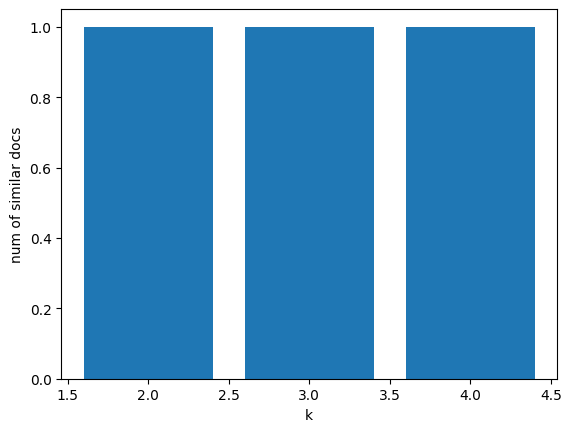

In [41]:
first_chart = []
for k in range(2,5):
    lsh_output, shingle_matrix, doc_names = lsh("docs", k,5,4)
    a = query2("sorgu.txt", shingle_matrix, doc_names, 5,4)
    first_chart.append(a)

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(2,5)
y = first_chart
plt.bar(x,y)
plt.xlabel("k")
plt.ylabel("num of similar docs")

Text(0, 0.5, 'num of similar docs')

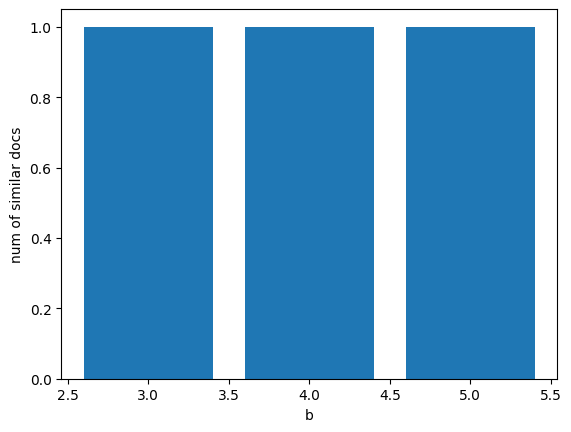

In [16]:
second_chart = []
lsh_output, shingle_matrix, doc_names = lsh("docs", 3,2,4)
for b in range(3,6):
    a = query2("sorgu.txt", shingle_matrix, doc_names, b,4)
    second_chart.append(a)

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(3,6)
y = second_chart
plt.bar(x,y)
plt.xlabel("b")
plt.ylabel("num of similar docs")

Text(0, 0.5, 'num of similar docs')

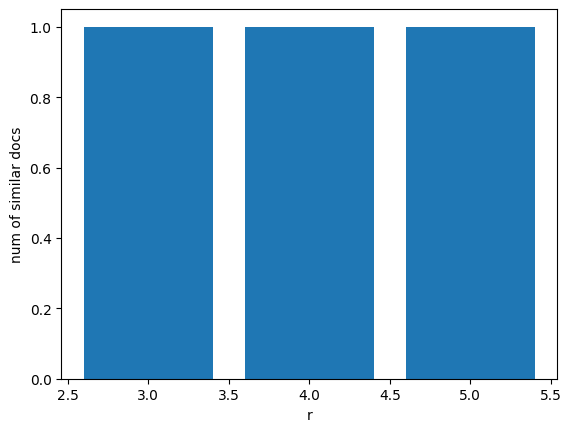

In [42]:
third_chart = []
lsh_output, shingle_matrix, doc_names = lsh("docs", 3,4,1)
for r in range(3,6):
    a = query2("sorgu.txt", shingle_matrix, doc_names, 4,r)
    third_chart.append(a)

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(3,6)
y = third_chart
plt.bar(x,y)
plt.xlabel("r")
plt.ylabel("num of similar docs")

**Soru 4**	Bu soruda MeanShift algoritmasını implement edeceksiniz. Yazacağınız metot verilen klasördeki her dosyayı meanShift algoritmasına ve radius uzaklık parametresine göre kümeler ve çıktı olarak kümeleri print eder. Algoritma en başta klasör içindeki her dosya için bir ağırlık merkezi başlatır. Çıktısı şu formatta olmalıdır.

Cluster-0: a,b,c

Cluster-1: d,e,f 

...........

Cluster-n: h
 
Yukarıdaki örnekte a,b,c, vs. verilen klasördeki dosyaların isimleridir. Dokümanların vektörel gösterimi şöyle olmalıdır: Tüm dokümanlarda geçen en popüler 1000 kelimeyi bulun. Sonra her kelimenin varlığı/yokluğunu birer öznitelik olarak gösterin. Örneğin bir doküman “a b c d f” ise ve b, d ve s en popüler ‘kelimeler’ ise, bu dokümanın gösterimi [1,1,0] olmalıdır. Uzaklık için kosinüs uzaklığını kullanın.



In [17]:
def zero_vec(length): # length uzunluğunda 0'lardan oluşan bir vektör döndürür
    vec = []
    for i in range(length):
        vec.append(0)
    return vec

def cos_distance(vec1,vec2):
    import numpy as np
    dot_p = np.dot(vec1,vec2)
    vec1_mag = np.sqrt(np.sum(np.square(vec1)))
    vec2_mag = np.sqrt(np.sum(np.square(vec2)))
    dist = 1.0 - (dot_p / (vec1_mag * vec2_mag))
    
    return dist

def meanShift(folder_name : str,radius : float, threshold : float):
    import os
    import string
    import random
    import numpy as np

    matrix_represent = dict() # holds different words as keys 

    dosya_isimleri = os.listdir(folder_name) # doc names in the folder

    for dosya in dosya_isimleri: 
        content = open(folder_name + "/" + dosya, "r").read()
        content = content.replace("\n", " ")
        content = content.lower()
        content = content.translate(str.maketrans('', '', string.punctuation))
        content = " ".join(content.split())        
        content = content.split(" ")
        for word in content:
            if word not in matrix_represent.keys():
                vec = zero_vec(len(dosya_isimleri))
                vec[dosya_isimleri.index(dosya)] = 1
                matrix_represent[word] = vec
            else:
                matrix_represent[word][dosya_isimleri.index(dosya)] = 1

    a = matrix_represent

    sum = dict()
    for key in a.keys():
        sum[key] = 0
        for value in a[key]:
            sum[key] += value

    sum = sorted(sum.items(), key=lambda x: x[1], reverse=True)
    
    for i in range(20,1,-1):
        pre = sum[0:i]
        post = sum[i:100]

        import statistics
        std = statistics.stdev([x[1] for x in post])

        mean = statistics.mean([x[1] for x in post])

        temp_dict = dict()
        if pre[i-1][1] > len(dosya_isimleri)-20:
            sum = sum[i:100+i]
            for key in sum:
                temp_dict[key[0]] = a[key[0]]

            a = temp_dict
    
    vector_rep = np.ndarray(shape=(len(dosya_isimleri), len(a.keys())), dtype=int)

    for doc in range(len(dosya_isimleri)):
        vec = zero_vec(len(a.keys()))
        for word in a.keys():
            if a[word][doc] > 0:
                vec[list(a.keys()).index(word)] = 1
            else:
                vec[list(a.keys()).index(word)] = 0
        vector_rep[doc] = vec

    sub_clusters = list()
    while True:
        for vec in vector_rep:
            vector_info = [vec, vec, False] # [original, center, is_clustered]
            while vector_info[2] == False:
                center = vector_info[1]
                close_vecs = []
                vec = np.array(vec)
                for vec2 in vector_rep:
                    vec2 = np.array(vec2)
                    if cos_distance(center, vec2) < radius:
                        close_vecs.append(vec2)

                if len(close_vecs) == 0:
                    vector_info[2] = True
                    sub_clusters.append(vector_info)
                    continue
                
                new_center = np.average(close_vecs, axis=0)
                new_center = np.array(new_center)

                center_move = cos_distance(new_center, vector_info[1])
                
                if center_move > threshold:
                    vector_info[1] = new_center
                else:
                    vector_info[2] = True
                    vector_info[1] = new_center
                    sub_clusters.append(vector_info)
        if len(sub_clusters) == len(vector_rep):
            break
    
    sub_clusters = [x[1] for x in sub_clusters]
    close_centers = dict()

    temp = 0
    for center in sub_clusters:
        close_centers[temp] = []
        for center2 in sub_clusters:
            if cos_distance(center, center2) < radius:
                close_centers[temp].append(center2)
        close_centers[temp] =  np.array(close_centers[temp])
        close_centers[temp] =  np.unique(close_centers[temp], axis=0)
        temp += 1
    clusters = []

    length = len(list(close_centers.keys()))

    for key in range(length):
        is_in = False # daha önce clusters'a eklenmiş mi?
        if close_centers[key] is None:
            continue
        for cluster in clusters:
            for cent in cluster:
                for cent2 in close_centers[key]:
                    if np.equal(cent, cent2).all():
                        is_in = True
                        break
                if is_in == True:
                    break
            if is_in == True:
                break
        if is_in == True:
            continue
        
        new_cluster = np.empty_like(close_centers[key])
        new_cluster = np.vstack((new_cluster, close_centers[key]))
        
        for key2 in range(key+1,length):
            is_in = False # yeni clusterda var mı? varsa onun da yakın olanlarını ekle
            if close_centers[key2] is None:
                continue
            for cent in close_centers[key2]:
                for cent2 in close_centers[key]:
                    if np.equal(cent, cent2).all():
                        is_in = True
                        break   
                if is_in == True:
                    break
            if is_in == True:
                new_cluster = np.vstack((new_cluster, close_centers[key2]))
                close_centers[key2] = None

        new_cluster = np.unique(new_cluster, axis=0)
       
        clusters.append(new_cluster)    
        
    clustering = dict()
    for idx, cluster in enumerate(clusters):
        clustering[idx] = []

    for idx,vec in enumerate(vector_rep):
        closest_cluster_idx = None
        closest_distance = float("inf")

        for idx2, cluster in enumerate(clusters):
            for cent in cluster:
                distance = cos_distance(vec, cent)
                if distance < closest_distance:
                    closest_distance = distance
                    closest_cluster_idx = idx2

        if closest_cluster_idx is not None:
            clustering[closest_cluster_idx].append(dosya_isimleri[idx])
        
    return clustering, len(clusters)

**Soru 5** 4. soruda tanımladığınız metodu kullanarak ödev ile beraber verilen docs klasöründeki dosyaları cluster ediniz. Bunun için radius değerinini 0.1’den başlayıp 0.05 arttırarak 0.95’e kadar tüm değerlerde deneyin ve elde ettiğiniz cluster sayısını gösteriniz. Bunun için x ekseninde Radius değeri, y ekseninde cluster sayısı olan bir figür oluşturunuz.

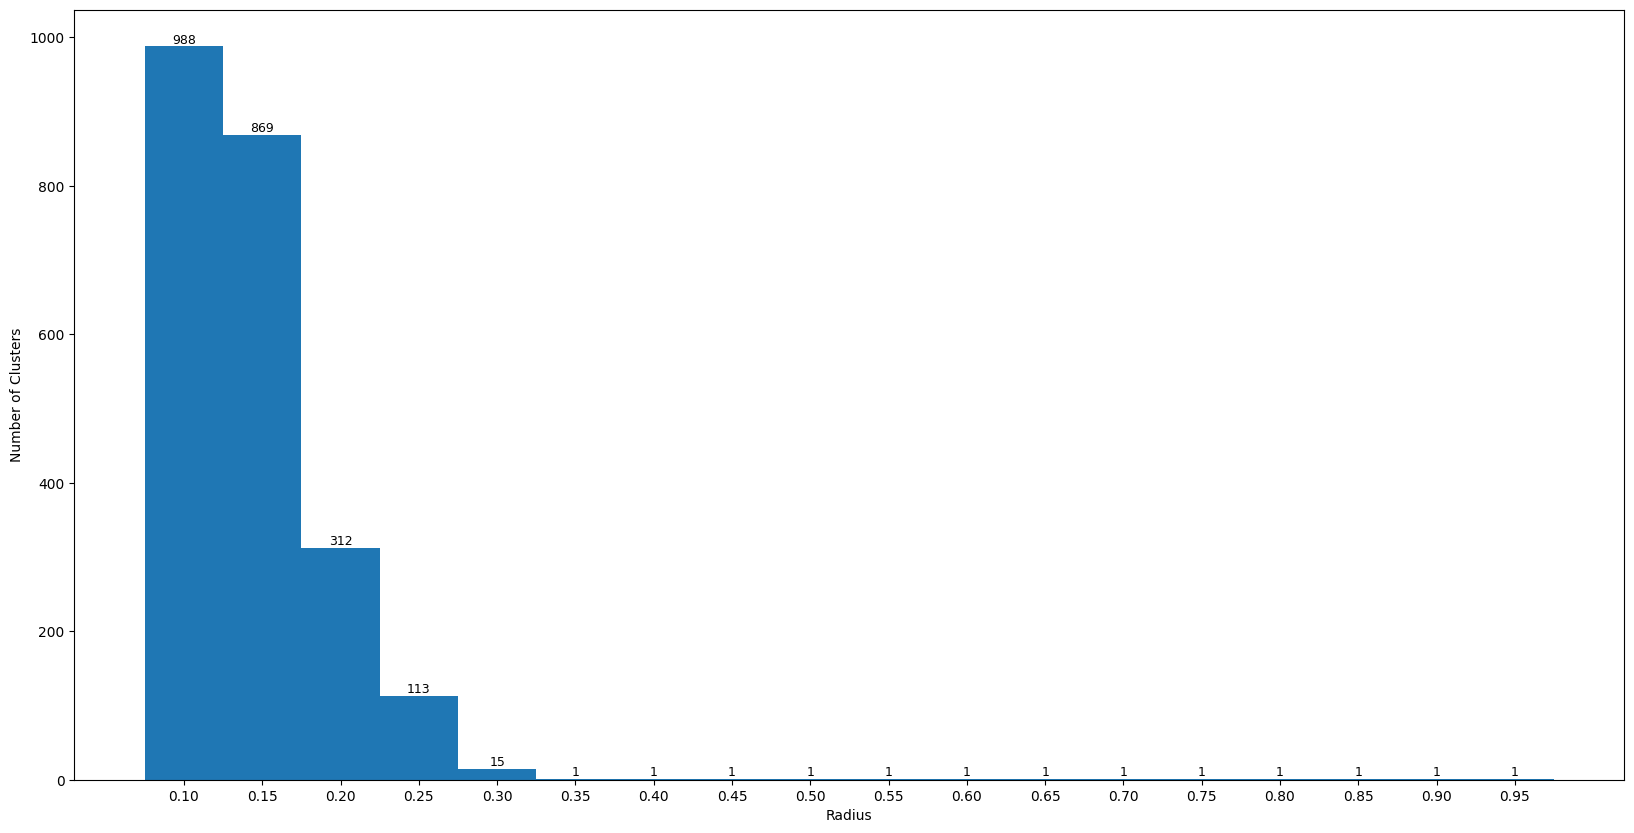

In [20]:
import numpy as np
radius_num_of_clusters = list()

for radius in np.arange(0.1, 1, 0.05):
    _,a = meanShift("docs", radius, 0.01)
    radius_num_of_clusters.append((radius,a))

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
x_values = [x[0] for x in radius_num_of_clusters]
y_values = [x[1] for x in radius_num_of_clusters]
bars = plt.bar(x_values,y_values, width=0.05)
plt.xticks(np.arange(0.1, 1, 0.05))

for bar, y in zip(bars, y_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(y),
             ha='center', va='bottom', fontsize=9)

plt.xlabel("Radius")
plt.ylabel("Number of Clusters")
plt.show()
